In [1]:
push!(LOAD_PATH,pwd())
using ProfileView
using constants
using types10
using Optim
using PyPlot
using dataPS
include("DOSfunctions.jl")
include("userfunctions.jl")
include("propertyfuncs.jl")

kltSA (generic function with 1 method)

In [2]:
Eoff=5.0
Ts=collect(300.0:10.0:900.0)
######################################################################################
##for Liu x=0.6 best fit x=0.635 N=-1.45e20
######################################################################################
numofn=[10.0e18]#,-1.22e18,-1.02e18,-0.94e18]#-9.5e19,-1.75e20,-3.0e19,-0.9e20]#Sample 1 -3.0e19, Sample 2 -1.25e20,
numofnn=[1e17]#,1e18,1e18,1e18]
#Sample 3 -1.75e20, Sample Sb 0.75% -1.03e20, #
xs=[0.6]#,0.8,0.7,0.61]#collect(0.0:0.01:1.0)
Es=collect(0.0:0.1:3.0)

var0=[Ts[1],xs[1]]

EX3(var)=Eoff#+Egx3(var[1],var[2])
EX1(var)=Ec0(var[2])+EX3(var)
ELH(var)=Eoff-Egx3(var[1],var[2])
EHH(var)=Eoff-Egx3(var[1],var[2])

effMassX1(var)=X1effMass(var[1])*me
effMassX3(var)=0.38*me
effMassLH(var)=-1.0*me
effMassHH(var)=-1.5*me

alphaX1(var)=0.0#EX1(var0)
alphaX3(var)=0.0#EX1(var0)
alphaLH(var)=0.0#EX3(var0)
alphaHH(var)=0.0#EX3(var0)

function Da(band::parBandTx,x::Float64)
    Da=7.0#9.0-1.5*x*x
    Dv=1.0
    if band==bandX3 ||  band==bandX1
        return Da
    end
    if band==bandHH ||  band==bandLH
        return Dv
    end
end

bandX3=parBandTx(true,1.0,effMassX3(var0),alphaX3(0.0),EX3(var0),[EX3],[effMassX3],[alphaX3],var0)
bandX1=parBandTx(true,1.0,effMassX1(var0),alphaX1(0.0),EX1(var0),[EX1],[effMassX1],[alphaX1],var0)
bandHH=parBandTx(true,1.0,effMassHH(var0),alphaHH(0.0),EHH(var0),[EHH],[effMassHH],[alphaHH],var0)
bandLH=parBandTx(true,1.0,effMassLH(var0),alphaLH(0.0),ELH(var0),[ELH],[effMassLH],[alphaLH],var0)
bndstTx=BandStrucTx([bandLH,bandHH,bandX1,bandX1,bandX1,bandX3,bandX3,bandX3],var0)#
#bndstTx=BandStrucTx([bandLH,bandX1],var0)#

#vartau0=[bandC.effMass,Ts[1],Ec(var0),xs[1],Ec(var0),bandC,numofn[1]*1e6,bndstTx,numofnn[1]*1e6,bandV]
vartau0=[bandX3.effMass,Ts[1],EX1(var0),xs[1],EX1(var0),bandX3,numofn[1]*1e6,bndstTx,numofnn[1]*1e6,bandLH]
#var array: var[1]: effMass , var[2]:T, var[3]:E, var[4]:x, var[5]:Ef, 
#var[6]:band, var[7]:NII var[8]:bndst
#tauAC(var)=tauAC_func(Cl(var[4]),acPhDa(var[4]),var[2],var[1],var[3],var[6])
tauAC(var)=tauAC_func(Cl(var[4]),Da(var[6],var[4]),var[2],var[1],var[3],var[6])
tauPOP(var)=tauPOP_func(epsilon0_x(var[4]),epsilonhf_x(var[4]),var[6],var[5],var[2],var[1]
,var[3],tauPOPIIint(var[5],var[2],var[4],var[6]),var[7],opPhE(var[4]),var[8])
tauPOP2(var)=tauPOP2lowN_func(epsilon0_x(var[4]),epsilonhf_x(var[4]),var[6],var[5],var[2],var[1],
var[3],opPhE(var[4]))
tauPOP3(var)=tauPOP3_func(epsilon0_x(var[4]),epsilonhf_x(var[4]),var[6],var[5],var[2],var[1],
var[3],opPhE(var[4]))
tauII2(var)=tauII2_func(epsilon0_x(var[4]),epsilonhf_x(var[4]),var[6],var[5],var[2],var[7],var[1],var[3],var[8])
tauNI(var)=tauNI_func(epsilon0_x(var[4]),var[1],var[9])
tauTOTTx=tau_electron_B([tauAC,tauII2,tauNI,tauPOP3],vartau0)#,tauII2,tauPOP2,tauPOP3

xmax=3.0

3.0

In [3]:
@time (Efs,sigmas,seebecks,kes,kees,kehs,kbis,sigmaes,sigmahs,seebeckes,seebeckhs)=electronicPropsiso(bndstTx,xs,Ts,numofn,numofnn,tauTOTTx,xmax)
x=3.0

 41.541652 seconds (232.80 M allocations: 42.997 GiB, 9.26% gc time)


3.0

In [4]:
T_EF_Dict=Dict()
for (Ti,Tx) in enumerate(Ts)
    T_EF_Dict[Tx]=(Efs[Ti])    
end
T_EF_Dict_Array=Array{Dict{Float64,Float64},2}(undef,length(numofn),length(xs))
Dict_temp=Dict()
Efsr=Array{Float64,3}(undef,length(Ts),length(numofn),length(xs))
for (j,jn) in enumerate(numofn)
    for (k,kx) in enumerate(xs) 
        for (i,iT) in enumerate(Ts)
            Efsr[i,j,k]=Efs[i,j,k]-EX3(0.0)
            Dict_temp[iT]=Efsr[i,j,k]
            T_EF_Dict_Array[j,k]=Dict_temp 
        end
    end
end
#foreach(i->println("$i= ",Ts[i]),1:length(Ts))
#Efsr

In [5]:
#println("-1")
#############Lattice Thermal Conductivity Parameters###############
function klpar(con::Float64,p::Float64,NP::Float64)
    thetaL=52.3e12*hbar/kB # K 
    thetaT=29.7e12*hbar/kB  # K
    vL=(1-con)*7700+con*4900    # m/s
    vT=(1-con)*4900+con*3000    # m/s
    gammaL=2.5*(1-con)+1.7*con
    gammaT=2.5*(1-con)+1.7*con
    M=(2*(24.305e-3)+(28.0855e-3*(1-con)+118.71e-3*con))/3/Nav
    V=((1-con)*(6.39e-10)^3+con*(6.77e-10)^3)/12
    a=V^(1.0/3.0)
    ro=M/V
    Vdj=(((6.39e-10)^3)/((1-con)*(6.39e-10)^3+con*(6.77e-10)^3))^(1/3)
    jL=vL/7700*Vdj
    jT=vT/4900*Vdj
    thetaLx=thetaL*jL
    thetaTx=thetaT*jT
    ##########Boundary Scattering###############3
    D=11e-9
    p=0.65
    ##########Alloy Scattering###################
    mbar=(28.0855*(1-con)+118.71*con)
    GammaSiSn=(1-con)*((28.0855-mbar)/mbar)^2+con*((118.71-mbar)/mbar)^2
    GammaMgSiSn=2*((mbar/(24.305+mbar))^2*GammaSiSn);         
    ##########Electron Scattering###################
    Ehp=1.0*q
    Eep=5.0*q
    xsp=xs[1]
    Tp=300.0
    mdx1=0.67*me
    mdx3=0.38*me
    mdLH=1.0*me
    mdHH=1.2*me
    Efx3=0.2589
    Efx1=0.2589
    ##########Nanoparticle Scattering###################
    #NP=0
    #alpha=1.0
    Rnp=5.0e-9#
    Vnp=4/3*pi*(Rnp)^3
    rhonp=NP/100/Vnp
    rhoM=3.0
    rhoT=3.78
    alphaNP=0.2289#1-exp(-1*(rhoT-rhoM)/rhoM);
#vartauPH0=[[0.02],Ts[1],gammaL,gammaT,xsp,thetaCLx,thetaCTx,thetaCTx,MSi,MGe,VSi,a,T_EF_Dict,0.0]
    Tsindex=1#25
    numberofnindex=1
    xsindex=1
    vartauPH0=[ [0.02],  Ts[1],   gammaL,  gammaT, con,#5
        thetaLx, thetaTx, thetaTx, M,   M, #10
        V, a, T_EF_Dict_Array, Eep, alphaNP, #15
        Rnp, thetaLx, thetaTx, vL, vT, #20
        vL, vT, p, NP,Tsindex,#25
        numberofnindex,xsindex,p,D,GammaMgSiSn,#30
        mdx1,mdx3,Efx1,Efx3,ro,#35,
        NP,alphaNP,Rnp,Vnp,rhonp, #40
        Ehp,mdHH,mdLH
        ]  
    thetaCLx=thetaCL(vartauPH0[12],vartauPH0[5],vartauPH0[17],vartauPH0[19],vartauPH0[11])
    thetaCTx=thetaCT(vartauPH0[12],vartauPH0[5],vartauPH0[18],vartauPH0[19],vartauPH0[11])
    #println("2")
    tauPHNLf(var)=tauPH_NL(var[3],var[11],var[1],var[2],var[9],var[21])
    tauPHNTf(var)=tauPH_NT(var[4],var[11],var[1],var[2],var[9],var[22]) 

    tauPHULf(var)=tauPH_U(var[3],var[1],var[2],var[9],var[19],var[17])
    tauPHUTf(var)=tauPH_U(var[4],var[1],var[2],var[9],var[20],var[18])

    tauPHALLLf(var)=tauPH_ALL(var[30],var[11],var[1],var[2],var[19])
    tauPHALLTf(var)=tauPH_ALL(var[30],var[11],var[1],var[2],var[20])
   
    tauPHeLfLH(var)=tauPH_e(var[41],var[43],var[35],(var[13][var[26],var[27]])[var[2]],var[1],var[2],var[21])
    tauPHeTfLH(var)=tauPH_e(var[41],var[43],var[35],(var[13][var[26],var[27]])[var[2]],var[1],var[2],var[22])

    tauPHeLfHH(var)=tauPH_e(var[41],var[42],var[35],(var[13][var[26],var[27]])[var[2]],var[1],var[2],var[21])
    tauPHeTfHH(var)=tauPH_e(var[41],var[42],var[35],(var[13][var[26],var[27]])[var[2]],var[1],var[2],var[22])


    tauPHeLfX3(var)=tauPH_e(var[14],var[32],var[35],(var[13][var[26],var[27]])[var[2]],var[1],var[2],var[21])
    tauPHeTfX3(var)=tauPH_e(var[14],var[32],var[35],(var[13][var[26],var[27]])[var[2]],var[1],var[2],var[22])

    tauPHeLfX1(var)=tauPH_e(var[14],X1effMass(var[2])*me,var[35],(var[13][var[26],var[27]])[var[2]]-Ec0(0.6)
        ,var[1],var[2],var[21])
    tauPHeTfX1(var)=tauPH_e(var[14],X1effMass(var[2])*me,var[35],(var[13][var[26],var[27]])[var[2]]-Ec0(0.6)
        ,var[1],var[2],var[22])

    tauPHBLf(var)=tauPH_B(var[19],var[28],var[29])
    tauPHBTf(var)=tauPH_B(var[20],var[28],var[29])
    #println("3")

    tauPHNPLf(var)=tauPH_NP(var[37],var[40],var[38],var[1],var[2],var[19])
    tauPHNPTf(var)=tauPH_NP(var[37],var[40],var[38],var[1],var[2],var[20])

    tauPHTOTL=tau_phonon_B([tauPHNLf,tauPHULf,tauPHBLf,tauPHALLLf,tauPHeLfLH,tauPHeLfHH,tauPHNPLf],vartauPH0)#,tauPHNPLf,tauPHALLLf,tauPHeLf,tauPH_eLf ,tauPHALLLf ,tauPHBLf,,tauPHULf
    tauPHNL=tau_phonon_B([tauPHNLf],vartauPH0) #tauPHeLfX3,tauPHeLfX1
    tauPHRL=tau_phonon_B([tauPHULf,tauPHBLf,tauPHALLLf,tauPHeLfLH,tauPHeLfHH,tauPHNPLf],vartauPH0) #,tauPHNPLf,tauPHALLLf,tauPHeLf,tauPHALLLf,tauPH_eLf] ,tauPHBLf

    tauPHTOTTx=tau_phonon_B([tauPHNTf,tauPHUTf,tauPHALLTf,tauPHeTfLH,tauPHeTfHH,tauPHBTf,tauPHNPTf],vartauPH0) #,tauPHNPTf,tauPHALLTf,tauPHeTf,tauPHALLTf,tauPH_eTf ,tauPHBTf
    tauPHNTx=tau_phonon_B([tauPHNTf],vartauPH0)
    tauPHRTx=tau_phonon_B([tauPHUTf,tauPHALLTf,tauPHeTfLH,tauPHeTfHH,tauPHBTf,tauPHNPTf],vartauPH0) #,tauPHNPTf,tauPHALLTf,tauPHeTf,tauPHALLTf,tauPH_eTf ,tauPHBTf#

    tauPHTOTTy=tau_phonon_B([tauPHNTf,tauPHUTf,tauPHBTf,tauPHALLTf,tauPHeTfHH,tauPHeTfLH,tauPHNPTf],vartauPH0) #,tauPHNPTf,tauPHALLTf,tauPHeTf,tauPHALLTf,tauPH_eTf tauPHBTf
    tauPHNTy=tau_phonon_B([tauPHNTf],vartauPH0)
    tauPHRTy=tau_phonon_B([tauPHUTf,tauPHBTf,tauPHALLTf,tauPHeTfHH,tauPHeTfLH,tauPHNPTf],vartauPH0) #,tauPHNPTf,tauPHALLTf,tauPH_eTf ,tauPHBTf,tauPHALLTf,tauPHeTf
    #println("4")
    tauPHL=[tauPHTOTL,tauPHNL,tauPHRL]
    tauPHTx=[tauPHTOTTx,tauPHNTx,tauPHRTx]
    tauPHTy=[tauPHTOTTx,tauPHNTx,tauPHRTx]
    return (vartauPH0,tauPHTOTL,tauPHNL,tauPHRL,tauPHTOTTx,tauPHNTx,tauPHRTx,tauPHTOTTy,tauPHNTy,tauPHRTy,tauPHL,tauPHTx,tauPHTy)
end
xmax=1.0

1.0

In [6]:
NPx=2.0
(vartauPH0,tauPHTOTL,tauPHNL,tauPHRL,tauPHTOTTx,tauPHNTx,tauPHRTx,
    tauPHTOTTy,tauPHNTy,tauPHRTy,tauPHL,tauPHTx,tauPHTy)=klpar(0.6,0.65,NPx)
klsM=Array{Float64}(undef,length(Ts),length(numofn),length(xs))
for (iT,iTx) in enumerate(Ts)    
   (IL1,ITx1,IL2,ITx2,IL3,ITx3,kL,kTx,kTy,klsM[iT,1,1])= klt(tauPHTOTL,tauPHNL,tauPHRL,tauPHTOTTx,tauPHNTx,tauPHRTx,tauPHTOTTy,tauPHNTy,
        tauPHRTy,iTx,[vartauPH0[21],vartauPH0[22],vartauPH0[22]])
    #println("T=", iTx, " kl= " ,round(klsM[iT,1,1]*10000)/10000)
   # println("IL1= ",IL1," IL2= ",IL2," IL3= ",IL3," ITx1= ",ITx1," ITx2= ",ITx2," ITx3= ",ITx3," kL/3=",kL,    " kTx/3=",kTx," kTy/3=",kTy)
end

In [7]:
(vartauPH0,tauPHTOTL,tauPHNL,tauPHRL,tauPHTOTTx,tauPHNTx,tauPHRTx,
    tauPHTOTTy,tauPHNTy,tauPHRTy,tauPHL,tauPHTx,tauPHTy)=klpar(0.0,0.65,NPx)
kls0=Array{Float64}(undef,length(Ts),length(numofn),length(xs))
for (iT,iTx) in enumerate(Ts)    
   (IL1,ITx1,IL2,ITx2,IL3,ITx3,kL,kTx,kTy,kls0[iT,1,1])= klt(tauPHTOTL,tauPHNL,tauPHRL,tauPHTOTTx,tauPHNTx,tauPHRTx,tauPHTOTTy,tauPHNTy,tauPHRTy,iTx,[vartauPH0[21],vartauPH0[22],vartauPH0[22]])
    #println("T=", iTx, " kl= " ,round(kls0[iT,1,1]*10000)/10000)
    #println("IL1= ",IL1," IL2= ",IL2," IL3= ",IL3," ITx1= ",ITx1," ITx2= ",ITx2," ITx3= ",ITx3," kL/3=",kL,    " kTx/3=",kTx," kTy/3=",kTy)
end

In [8]:
(vartauPH0,tauPHTOTL,tauPHNL,tauPHRL,tauPHTOTTx,
    tauPHNTx,tauPHRTx,tauPHTOTTy,tauPHNTy,tauPHRTy,tauPHL,tauPHTx,tauPHTy)=klpar(1.0,0.5,NPx)
kls1=Array{Float64}(undef,length(Ts),length(numofn),length(xs))
for (iT,iTx) in enumerate(Ts)    
   (IL1,ITx1,IL2,ITx2,IL3,ITx3,kL,kTx,kTy,kls1[iT,1,1])= klt(tauPHTOTL,tauPHNL,tauPHRL,tauPHTOTTx,tauPHNTx,tauPHRTx,tauPHTOTTy,tauPHNTy,tauPHRTy,iTx,[vartauPH0[21],vartauPH0[22],vartauPH0[22]])
   # println("T=", iTx, " kl= " ,round(kls1[iT,1,1]*10000)/10000)
   # println("IL1= ",IL1," IL2= ",IL2," IL3= ",IL3," ITx1= ",ITx1," ITx2= ",ITx2," ITx3= ",ITx3," kL/3=",kL,    " kTx/3=",kTx," kTy/3=",kTy)
end

In [9]:
yaa=0.6
aMgSi=6.39e-10
aMgSn=6.77e-10
ks=Array{Float64}(undef,length(Ts),length(numofn),length(xs))
klsT=Array{Float64}(undef,length(Ts),length(numofn),length(xs))
f=0.30
for (iT,iTx) in enumerate(Ts)  
    klsT[iT,1,1]=(1-f)*klsM[iT,1,1]+f*(kls1[iT,1,1]*(1-yaa)aMgSn^3/((1-yaa)*aMgSn^3+yaa*aMgSi^3)+kls0[iT,1,1]*(yaa)aMgSi^3/((1-yaa)*aMgSn^3+yaa*aMgSi^3))
       ks[iT,1,1]=klsT[iT,1,1]+kes[iT,1,1]+kbis[iT,1,1,] 
    #println("T=", iTx, " kl= " ,round(klsT[iT,1,1]*10000)/10000)
    #println("IL1= ",IL1," IL2= ",IL2," IL3= ",IL3," ITx1= ",ITx1," ITx2= ",ITx2," ITx3= ",ITx3," kL/3=",kL,    " kTx/3=",kTx," kTy/3=",kTy)
end

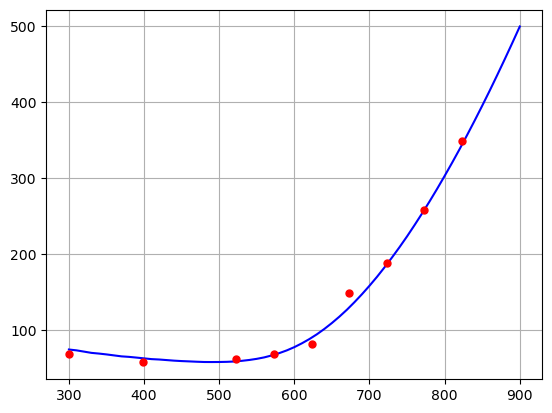

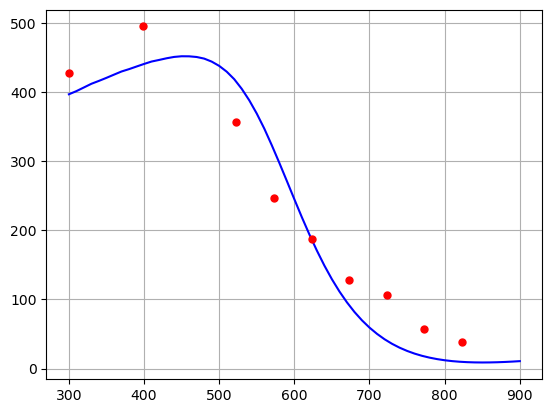

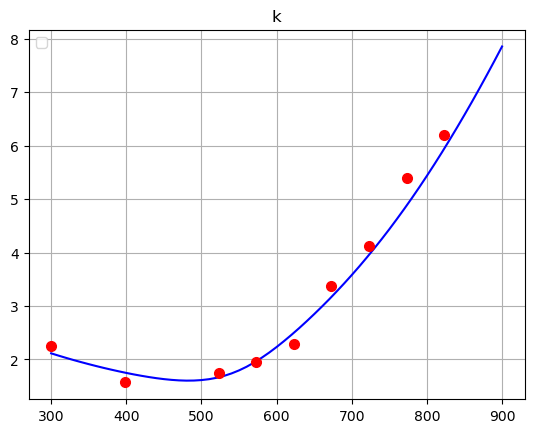

No handles with labels found to put in legend.


In [10]:
figure()
plot(Ts,sigmas[:,1,1]/100,linestyle="-",color="b")
plot(MgSiSn4hKCT .+273,MgSiSn2h2TiO2ECE,linestyle="None",marker=".",markersize=10,color="r")
grid()
figure()
plot(Ts,seebecks[:,1,1]*1e6,linestyle="-",color="b")
plot(MgSiSn4hKCT .+273,MgSiSn2h2TiO2SCS,linestyle="None",marker=".",markersize=10,color="r")
grid()
figure()
title("k")
plot(Ts,klsT[:,1,1]+kes[:,1,1]+kbis[:,1,1],linestyle="-",color="b")
plot(MgSiSn4hKCT .+273,MgSiSn2h2TiO2KCK,linestyle="None",marker="o",markersize=7,color="r")

legend(loc="upper left")
#ylim(1.5,3.5)
grid()

In [11]:
Ts

61-element Array{Float64,1}:
 300.0
 310.0
 320.0
 330.0
 340.0
 350.0
 360.0
 370.0
 380.0
 390.0
 400.0
 410.0
 420.0
   ⋮
 790.0
 800.0
 810.0
 820.0
 830.0
 840.0
 850.0
 860.0
 870.0
 880.0
 890.0
 900.0

In [12]:
foreach(x->println(ks[x,1,1]),1:length(Ts))

2.114911752579714
2.0715811701569145
2.029555296038887
1.9890012634478937
1.9502954209749188
1.9129673063795771
1.876987456244495
1.8424497994615499
1.8097979069486752
1.7784900188493025
1.7487558281700994
1.720784642047751
1.6952239847427295
1.671655707475668
1.650655965937349
1.6329123355203434
1.6189579048823666
1.609170021315759
1.6044549378883926
1.6061878579227218
1.6148702170297378
1.631410502150041
1.6568457738663664
1.6929297614678456
1.739122734443551
1.7959374458294712
1.8634451999337454
1.9427396288532317
2.030976113941413
2.12784192115002
2.2329786248558428
2.3455693804866797
2.463440089387627
2.5863838496080995
2.7150346797042686
2.848052249573213
2.9850307243035137
3.126266091170062
3.2731294347677826
3.424111290786877
3.5796242341527416
3.740024227834632
3.9067760790304886
4.078103990573567
4.254662742548332
4.436675695844543
4.6254918651967944
4.819155415290283
5.018384207888106
5.22379124705021
5.435063195799129
5.651709416569801
5.873949145378093
6.102444650873399
6.

In [13]:
foreach(x->println(sigmas[x,1,1]),1:length(Ts))

7406.5554371833405
7297.205691314944
7132.063979805168
6964.388013976264
6872.353509424956
6761.309575981696
6632.6919321774085
6504.686765973465
6438.4261659229405
6342.603282990161
6240.999094657869
6141.771254553652
6092.07196055574
6015.853873183035
5940.330328387924
5884.765339338978
5843.473793223637
5799.076287546355
5763.403040531571
5757.944962742241
5763.912040728129
5784.458247649286
5827.786872218374
5916.282634441447
6029.712535733009
6178.973207888665
6371.57844422815
6630.388440038836
6933.312626948915
7293.199519887218
7720.841911407992
8220.737302757476
8782.026834786415
9410.977755193153
10119.453795891532
10896.86607693414
11739.503742668956
12649.225175838248
13639.114865177866
14689.617527304415
15801.679963495882
16975.79448634053
18226.8420606804
19529.625442874294
20889.10616476233
22305.44056118624
23794.829059753785
25328.71558486235
26915.062842022628
28561.282247834155
30261.965745301197
32009.076298835822
33805.11636166817
35659.645030724845
37560.293422083

In [14]:
foreach(x->println(-seebecks[x,1,1]*1e6),1:length(Ts))

-396.89074976808234
-401.46094624041314
-406.7699257201937
-412.1128118984566
-416.2867701797989
-420.68391423299965
-425.3028412093253
-429.85332126200467
-433.2663114630595
-437.0505987654282
-440.78185873808604
-444.2712372027117
-446.5664101162433
-448.9913272803609
-450.94106958287665
-451.90206442756505
-451.8127505625232
-450.8370508476617
-448.52392027855865
-444.18017568285774
-437.9638538963329
-429.5932363588345
-418.71884069227883
-404.74757348840296
-388.1714081950476
-368.9363147183968
-347.23481029986146
-323.1069905836968
-297.705711298482
-271.4987059385609
-245.0412889615109
-218.9801354402678
-194.08718697281986
-170.69910104167323
-148.97680553003005
-129.22759708162627
-111.52573458862774
-95.80432648929327
-81.88104207886335
-69.75861573196624
-59.261788154743655
-50.220410788256814
-42.42682476603751
-35.82163221614111
-30.241065735543046
-25.55588652308252
-21.62721714324421
-18.40519316785845
-15.783931214365955
-13.678345802081063
-12.027747347771399
-10.77778

In [15]:
foreach(x->println(kes[x,1,1]),1:length(Ts))

0.041780724229692104
0.0432466758975511
0.0443809605687038
0.04538045302759644
0.04664925385706623
0.04774318552145258
0.04865004009584576
0.04946573239111236
0.05059948857932757
0.05147648206790745
0.05224071872363628
0.05294972783224612
0.05398942195088286
0.05476717370562434
0.05549452202884077
0.05634808547534311
0.057292397726829855
0.05816706270139309
0.059085578213750434
0.060277391293372395
0.061560333668648874
0.06297093897999774
0.064605594246358
0.06673476366940463
0.0691386401035075
0.0719554668307349
0.07529108817838187
0.07945536686718943
0.08419020109475936
0.08968176637929415
0.09610189948291092
0.10354653768385502
0.11189759204266181
0.12127533918221378
0.13189187604681685
0.14363316757588418
0.1564801201318391
0.1704984043887373
0.18593831097567648
0.20252967508845832
0.22032274809114927
0.23936188017631
0.25994278396391923
0.2816704078281014
0.30466239451009813
0.32895487229224507
0.3548822658823938
0.3819542028422307
0.41034674815301786
0.4402343969268736
0.47154790

In [16]:
foreach(x->println(kbis[x,1,1]),1:length(Ts))

1.3627231823347148e-5
2.8276794050311718e-5
5.560346606722271e-5
0.0001048889410748571
0.00019300730640197473
0.000342114784631668
0.0005858386125161718
0.0009744610993263545
0.0015951676099565163
0.0025338127153410645
0.003928339652263864
0.005961886218993197
0.008946253807396705
0.013104737925089623
0.018849253962986354
0.02673643913723288
0.03737884697059918
0.05135650302160833
0.06950271690315106
0.0930020781345313
0.12257532345292103
0.15912987005833068
0.20364022567397086
0.25762190445724675
0.32078569521496925
0.3935353333200225
0.47586406969357875
0.5685820824147788
0.6691279347410253
0.7770265233624482
0.8917701744253452
1.0124675342902778
1.1370829193671637
1.2653084334020979
1.3975842938942908
1.5327015708141676
1.6702900100621805
1.8105955876621962
1.9547539762299746
2.1015400180503745
2.2513294826358354
2.404446771230978
2.5620731453310706
2.7228394384948573
2.887293811076729
3.055633992498394
3.228884571597013
3.40558961291433
3.586299994388876
3.7714628836009525
3.960842

In [17]:
foreach(x->println(klsT[x,1,1]),1:length(Ts))

2.0731174011181985
2.028306217465313
1.985118732004116
1.9435159214792224
1.9034531598114506
1.864882006073493
1.827751577536133
1.7920096059711113
1.757603250759391
1.7244797240660539
1.6925867697941994
1.6618730279965117
1.6322883089844498
1.603783795844954
1.576312189945522
1.5498278109077674
1.5242866601849376
1.4996464555927576
1.475866642771491
1.4529083884948182
1.430734559908168
1.4093096931117124
1.3885999539460376
1.3685730933411941
1.3491983991250742
1.3304466456787138
1.3122900420617847
1.2947021795712634
1.2776579781056285
1.2611336314082777
1.2451065509475863
1.229555308512547
1.2144595779778014
1.1998000770237878
1.185558509763161
1.1717175111831613
1.1582605941094941
1.1451720991191288
1.1324371475621313
1.1200415976480442
1.107972003425757
1.096215576427344
1.084760149735499
1.0735941442506085
1.0627065369615045
1.052086831053904
1.041725027717388
1.0316115995337225
1.0217374653462117
1.0120939665223836
1.0026728445315225
0.9934662197653674
0.984466571535367
0.97566671